In [10]:
# If not installed, run this cell. It is needed for access to GEE
#!pip install ee
#!pip show ee

In [11]:
# If not installed, run this cell. It helps visualization of data
#!pip install geemap
#!pip show geemap

In [12]:
# Import libraries
import ee, datetime, pandas as pd, geemap, ipyleaflet, ipywidgets as widgets, matplotlib.pyplot as plt
import calendar

In [13]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jvg')

In [14]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
hydrobasins = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_3')
hybas_id = "HYBAS_ID"
Map = geemap.Map()
Map.addLayer(hydrobasins, {}, 'HydroBasins')
#vector_layer = Map.find_layer("HydroBasins")
#vector_layer.interact(opacity=(0, 1, 0.1))

In [15]:
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = ipyleaflet.WidgetControl(widget=output_widget, position="bottomright")
Map.add_control(output_control)

In [16]:
# This ID and lat and lon will be identified through the interative map above by clicking on the basin of your interest.
# See the widget on the bottom right side of the map
# Define the basin and location of interest
selected_basin_id = None
lat = None
lon = None

def remove_layer(pre_name):
    layer_names = Map.layers # Get the list of layer names
    layers = Map.layers[:]  # Get the list of layers
    names = [layer.name for layer in layer_names]  # Extract layer names

    for item in names:
        if pre_name in item: # Check if the name is in the item
            index = names.index(item)  # Get the index of the name
            layer = layer_names[index]  # Retrieve the layer at the index
            Map.remove(layer)  # Remove the layer from the map    
            return Map.layers[:]
  
    return layers

# Function to identify the ID of the basin of interest by clicking on the map over the feature of the HydroSHEDS
def handle_interaction(**kwargs):
    global selected_basin_id
    global lat
    global lon

    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        lat = latlon[0]
        lon = latlon[1]
        xy = ee.Geometry.Point(latlon[::-1])
        selected_fc = hydrobasins.filterBounds(xy)

        with output_widget:
            output_widget.clear_output()

            try:
                pre_name = "Identified Basin: "
                Map.layers = remove_layer(pre_name)
                selected_basin_id = selected_fc.first().get(hybas_id).getInfo()
                geom = selected_fc.geometry()
                layer_name = pre_name + str(selected_basin_id)
                Map.addLayer(ee.Image().paint(geom, 0, 2), {'palette': 'red'}, layer_name)
                print(layer_name + "\nLat: " + str(lat) + " Long: " + str(lon))
            except Exception as e:
                print('No feature could be found')
                Map.layers = Map.layers[:]

        Map.default_style = {'cursor': 'pointer'}

Map.on_interaction(handle_interaction)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [17]:
# Function to determine the simulation period and the reporting period
def determine_period(start_date, end_date, warmup_yrs = 0):
    ini_date = str((int(start_date.split("-")[0]) + int(warmup_yrs))) + "-" + start_date.split("-")[1]
    if (end_date.split("-")[1]) == "12":
        fin_date = str(int(end_date.split("-")[0]) + 1) + "-01"
    else:
        fin_date = str(int(end_date.split("-")[0])) + "-" + str(int(end_date.split("-")[1]) + 1)

    if (datetime.datetime(int(ini_date.split("-")[0]), int(ini_date.split("-")[1]), 1) >= datetime.datetime(int(fin_date.split("-")[0]), int(fin_date.split("-")[1]), 1)):
        if (warmup_yrs != 0):
            print ("Start date is finally set beyond or same as the end date! Please consider the implications of the warm-up years. Remember that end date is exclusive")
        else:
            print ("Start date is finally set beyond or same as the end date! Please review your input dates. Remember that end date is exclusive")
        raise SystemExit()

    print ("Simulation period will be from " + start_date + " to " + end_date
           + "; however, outputs will be provided for " + ini_date + " to " + end_date)
    return ini_date, fin_date

In [21]:
## Initial parameters ##

# It is recommended using at least 5 years of equilibration period - warm up years. This allows the model to get the water cycling properly.
# When a proper equilibration period is incorporated, "ffcb" value is not going to impact model results
warmup_yrs = 5
start_date = '2008-01'
end_date = '2023-12'
ini_date, fin_date = determine_period(start_date, end_date, warmup_yrs)
#selected_basin_id = 6030016970 # This ID must be identified through the interative map above by clicking on the basin of your interest. See the widget on the bottom right side of the map

Simulation period will be from 2008-01 to 2023-12; however, outputs will be provided for 2013-01 to 2023-12


In [22]:
######################################################
### Starting values for the water balance model - T&M
######################################################

# The recession constant (k) will be determined from hydrographs derived from the gathered streamflow datasets. For the rest of the world, k will be defined as 0.5
k_recession = 0.5 # Temporarily is defined as such

# Initial soil water storage expressed as a fraction of water holding capacity [0-1]
ffcb = 0.1 # 10%

# Base flow of the previous month (mm)
bflow_ant = 10

In [23]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
zoi = hydrobasins.select(hybas_id).filter(ee.Filter.eq(hybas_id, selected_basin_id))
visualization = {
  "color": 'blue',
  "strokeWidth": 1
}
Map.centerObject(zoi.geometry())
Map.addLayer(zoi, visualization, 'Selected Basin')

In [24]:
# Public link to the asset whc: https://code.earthengine.google.com/?asset=projects/ee-jvg/assets/whc_fc33
whc = ee.Image('projects/ee-jvg/assets/whc_fc33')
whc = whc.clip(zoi).divide(1000) # As the raster was originally multiplied by 1000
Map.addLayer(whc, {}, 'Water Holding Capacity')

In [25]:
# TerraClimate layers filtered with "start_date" (inclusive) and "end_date" (exclusive) and clipped to "zoi"
terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date(start_date, fin_date)).map(lambda image: image.clip(zoi))
num_months = terraclimate.size().getInfo()
num_months

192

In [26]:
# Initial images and time to start the water balance
k = ee.Image(k_recession)
st0 = whc.multiply(ffcb)
bf0 = ee.Image(bflow_ant)
time0 = terraclimate.first().get("system:time_start") # Define the initial time (time0) according to the start of the collection

In [27]:
# Initialization of ALL bands.
# Mandatory to cast the type of the data with a .float().

# Initialization of precipitation
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

# Initialization of runoff
initial_ro = ee.Image(0).set("system:time_start", time0).select([0], ["ro"]).float()

# Initialization of effective precipitation
initial_ep = ee.Image(0).set("system:time_start", time0).select([0], ["eprec"]).float()

# Initialization of actual evapotranspiration
initial_aet = ee.Image(0).set("system:time_start", time0).select([0], ["aet"]).float()

# Initialization of soil storage, which is considered to be a fraction of WCH
initial_st = st0.set("system:time_start", time0).select([0], ["sstor"]).float()

# Initialization of percolation
initial_pc = ee.Image(0).set("system:time_start", time0).select([0], ["perc"]).float()

# Initialization of base flow, which is considered as defined in Ulmen (2000)
initial_bf = bf0.set("system:time_start", time0).select([0], ["bflow"]).float()

# Initialization of water yield
initial_wy = ee.Image(0).set("system:time_start", time0).select([0], ["wyield"]).float()

In [28]:
# All initial bands are combined into one "ee.Image" by adding them to the first band (wy)
initial_image = initial_wy.addBands(
    ee.Image([initial_pr, initial_pet, initial_ro, initial_ep, initial_aet, initial_st, initial_pc, initial_bf])
)

# Initiatlization of list that will contain new images after each iteration
image_list = ee.List([initial_image])

In [29]:
def water_balance(image, image_list):
    
    # Determine the date of the current ee.Image of the collection.
    localdate = image.get('system:time_start')

    # Import previous image stored in the list
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # Import previous soil storage and baseflow
    # Only those variables of the water balance that work with previous conditions (i.e., i-1)
    prev_st = prev_im.select("sstor")
    prev_bf = prev_im.select("bflow")

    # Import current precipitation, potential evapotranspiration, and runoff
    pr_im = image.select("pr")
    pet_im = image.select("pet").multiply(0.1) # Scale factor: 0.1
    ro_im = image.select('ro')

    # Initialize the new bands associated with wyield, eprec, aet, perc, sstor, and bflow
    new_wy = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["wyield"])
        .float()
    )

    new_ep = (
        pr_im.subtract(ro_im)
        .set("system:time_start", localdate)
        .select([0], ["eprec"])
        .float()
    )

    new_aet = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["aet"])
        .float()
    )

    new_pc = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["perc"])
        .float()
    )

    new_st = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["sstor"])
        .float()
    )

    new_bf = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["bflow"])
        .float()
    )

    # Calculate bands depending on the situation using binary layers with logical operations

    ## CASE 1
    # Define zone1: pixels where EPREC > PET 
    zone1 = new_ep.gt(pet_im)

    # Calculation of AET in zone 1
    zone1_aet = pet_im.rename("aet")
    # Implementation of zone 1 values for AET
    new_aet = new_aet.where(zone1, zone1_aet)

    ## CASE 1.1
    # Define zone11: pixels where (EPREC > PET) and (Si-1 + EPREC - AET > WHC)
    zone11 = zone1.And(prev_st.add(new_ep).subtract(new_aet).gt(whc))

    # Calculation of SSTOR in zone 1.1
    zone11_st = whc.rename("sstor")
    # Implementation of zone 1.1 values for SSTOR
    new_st = new_st.where(zone11, zone11_st)

    # Calculation of PERC in zone 1.1
    zone11_pc = prev_st.add(new_ep).subtract(new_aet).subtract(whc).rename("perc")
    # Implementation of zone 1.1 values for PERC
    new_pc = new_pc.where(zone11, zone11_pc)

    ## CASE 1.2
    # Define zone12: pixels where (EPREC > PET) and (Si-1 + EPREC - AET <= WHC)
    zone12 = zone1.And(prev_st.add(new_ep).subtract(new_aet).lte(whc))

    # Calculation of SSTOR in zone 1.2
    zone12_st = prev_st.add(new_ep).subtract(new_aet).rename("sstor")
    # Implementation of zone 1.2 values for SSTOR
    new_st = new_st.where(zone12, zone12_st)

    ## CASE 2
    # Define zone2: pixels where EPREC <= PET
    zone2 = new_ep.lte(pet_im)

    # Calculation of SSTOR in zone 2
    zone2_st = prev_st.multiply(ee.Image.exp(new_ep.subtract(pet_im).abs().divide(whc).multiply(-1))).rename("sstor")
    # Implementation of zone 2 values for SSTOR
    new_st = new_st.where(zone2, zone2_st)

    # Calculation of AET in zone 2
    zone2_aet = new_ep.add(new_st).subtract(prev_st).rename("aet")
    # Implementation of zone 2 values for AET
    new_aet = new_aet.where(zone2, zone2_aet)

    new_bf_p1 = prev_bf.multiply(k)
    new_bf_p2 = ee.Image(1).subtract(k).multiply(new_pc)
    new_bf = new_bf.add(new_bf_p1).add(new_bf_p2).rename("bflow")

    new_wy = new_wy.add(new_bf).add(ro_im).rename("wyield")

    # Create a mask around area where pixels can effectively be calculated
    # Where we have have PREC as TerraClimate and WHC
    mask = pr_im.gte(0).And(whc.gte(0))
    
    # Apply the mask
    new_wy = new_wy.updateMask(mask)

    # Add all Bands to our ee.Image
    new_image = new_wy.addBands(ee.Image([pr_im, pet_im, ro_im, new_ep, new_aet, new_st, new_pc, new_bf]))
    new_image = new_image.set("system:time_start", localdate) # Needed to have 'start_time' finally assigned correctly
    
    # Add the new ee.Image to the ee.List
    return ee.List(image_list).add(new_image)

In [30]:
#########################
# WATER BALANCE EXECUTION
#########################

# Iterate the user-supplied function to the terraclimate collection
wy_list = terraclimate.iterate(water_balance, image_list)

# Remove the initial image from our list
wy_list = ee.List(wy_list).remove(initial_image)

# Transform the list into an ee.ImageCollection
wy_coll = ee.ImageCollection(wy_list).filter(ee.Filter.date(ini_date, fin_date))

In [31]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms").dt.strftime("%Y-%m")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

In [32]:
# The point location was previously defined by clicking on the map
poi = ee.Geometry.Point(lon, lat)
poi_ft = ee.FeatureCollection(ee.Geometry.Point(lon, lat))
Map.addLayer(poi_ft, {'color': 'red', 'pointSize': 10}, "Point of Interest")

# A nominal scale in meters of the projection to work in [in meters]
scale = 250

In [63]:
# Function to convert image samples to a pandas DataFrame
def get_sample_as_df(image):
    # Sample points from the image at the location `poi`
    sample = image.sample(region=poi, scale=scale).getInfo()  # Earth Engine operation (server-side)

    # Convert the Earth Engine sample to a pandas DataFrame client-side
    df = ee_array_to_df(sample, wb_vars)  # ee_array_to_df is your conversion function to handle the sample
    return df

# List to store DataFrames
df_list = []
# Get the size of the collection.
collection_size = wy_coll.size().getInfo()
wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]

# Map over the image collection and collect samples
for index in range(len(wy_coll.getInfo()['features'])):
    # Convert each image sample to a pandas DataFrame
    df = get_sample_as_df(ee.Image(wy_coll.toList(collection_size).get(index)))
    
    # Append to the list of DataFrames
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df1 = pd.concat(df_list).sort_index()
df1

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [33]:
# Let's have a look at the result around a location of interest:
# WARNING: It crashes if the number of simulation years is greater than 11 on a monthly basis, i.e., more than 132 images
arr = wy_coll.getRegion(poi, scale).getInfo()
wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
rdf = ee_array_to_df(arr, wb_vars).sort_index()
rdf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
2013-01,1356998400000,215,78.7,136,79,78.700000,49.507000,0.300000,22.052216,158.052216
2013-02,1359676800000,445,76.4,368,77,76.400000,49.507000,0.600000,11.326108,379.326108
2013-03,1362096000000,280,82.9,198,82,81.108131,48.615131,0.000000,5.663054,203.663054
2013-04,1364774400000,344,76.8,267,77,76.800000,48.815131,0.000000,2.831527,269.831527
2013-05,1367366400000,165,75.2,89,76,75.200000,49.507000,0.108131,1.469829,90.469829
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,30,121.9,2,28,26.757920,0.219298,0.000000,0.148328,2.148328
2023-09,1693526400000,16,130.1,1,15,14.802147,0.021445,0.000000,0.074164,1.074164
2023-10,1696118400000,34,134.4,2,32,31.981265,0.002710,0.000000,0.037082,2.037082


In [35]:
#Get values of initial variables for the point of interest
copy_ii = initial_image.set('system:time_start', 0)
intial_imgs = ee.ImageCollection(ee.List([copy_ii]))
initial_arr = intial_imgs.getRegion(poi, scale).getInfo()
idf = ee_array_to_df(initial_arr, wb_vars).sort_index()
idf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0,0,0,0,4.9507,0,10,0


In [36]:
rdff = pd.concat([idf, rdf])
#rdf.to_excel("D:\Borrar\wb_point.xlsx")
#rdff.to_csv("D:\Borrar\wb_point.csv")
rdff

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0.0,0,0,0.000000,4.950700,0.00000,10.000000,0.000000
2013-01,1356998400000,215,78.7,136,79,78.700000,49.507000,0.30000,22.052216,158.052216
2013-02,1359676800000,445,76.4,368,77,76.400000,49.507000,0.60000,11.326108,379.326108
2013-03,1362096000000,280,82.9,198,82,81.108131,48.615131,0.00000,5.663054,203.663054
2013-04,1364774400000,344,76.8,267,77,76.800000,48.815131,0.00000,2.831527,269.831527
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,30,121.9,2,28,26.757920,0.219298,0.00000,0.148328,2.148328
2023-09,1693526400000,16,130.1,1,15,14.802147,0.021445,0.00000,0.074164,1.074164
2023-10,1696118400000,34,134.4,2,32,31.981265,0.002710,0.00000,0.037082,2.037082


In [37]:
# Preparing dataframe for chart visualization
new_pd = rdf.drop(["time", "pet", "eprec", "sstor", "perc"], axis=1)
new_pd["year"] = new_pd.apply(lambda row: row.name.split("-")[0], axis=1)
new_pd["month"] = new_pd.apply(lambda row: calendar.month_abbr[int(row.name.split("-")[1])], axis=1)
new_pd

,pr,ro,aet,bflow,wyield,year,month
datetime,,,,,,,
2013-01,215,136,78.700000,22.052216,158.052216,2013,Jan
2013-02,445,368,76.400000,11.326108,379.326108,2013,Feb
2013-03,280,198,81.108131,5.663054,203.663054,2013,Mar
2013-04,344,267,76.800000,2.831527,269.831527,2013,Apr
2013-05,165,89,75.200000,1.469829,90.469829,2013,May
...,...,...,...,...,...,...,...
2023-08,30,2,26.757920,0.148328,2.148328,2023,Aug
2023-09,16,1,14.802147,0.074164,1.074164,2023,Sep
2023-10,34,2,31.981265,0.037082,2.037082,2023,Oct


In [38]:
# Annual values
pd_yr = new_pd.drop("month", axis=1).groupby(["year"]).sum()
pd_yr

,pr,ro,aet,bflow,wyield
year,,,,,
2013,2436,1426,850.707750,98.175345,1524.175345
2014,2012,1013,828.016216,61.318567,1074.318567
2015,1853,896,710.205202,92.131060,988.131060
2016,2538,1472,882.320031,140.720923,1612.720923
2017,2493,1440,853.089685,93.644509,1533.644509
2018,2617,1615,829.386628,85.810241,1700.810241
2019,2989,2048,766.965202,78.369948,2126.369948
2020,2161,1170,761.329009,88.192740,1258.192740
2021,2296,1349,711.822246,152.814075,1501.814075


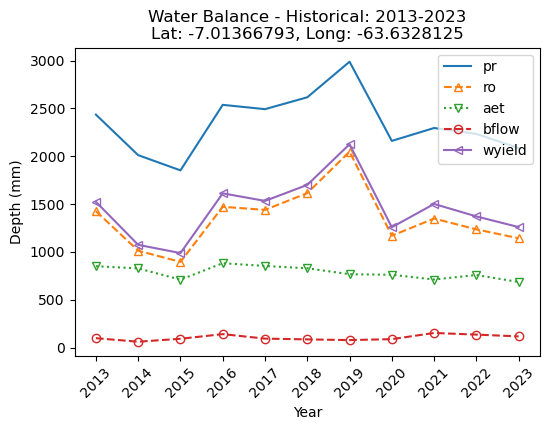

In [39]:
# Plot of yearly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_yr.columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_yr[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [40]:
# Monthly values
pd_month = new_pd.drop("year", axis=1).groupby(["month"], sort=False).mean()
pd_month

,pr,ro,aet,bflow,wyield
month,,,,,
Jan,309.090909,230.727273,77.992523,14.886326,245.613599
Feb,345.181818,271.818182,73.055222,7.515932,279.334113
Mar,349.363636,268.272727,80.667856,3.799008,272.071735
Apr,292.727273,213.272727,79.246182,1.931395,215.204122
May,139.000000,54.636364,81.719601,1.034267,55.670631
Jun,43.636364,2.272727,10.591457,0.517134,2.789861
Jul,16.363636,0.818182,1.672638,0.258567,1.076749
Aug,43.181818,2.181818,39.454078,0.129283,2.311102
Sep,82.818182,4.181818,66.834680,0.919152,5.100970


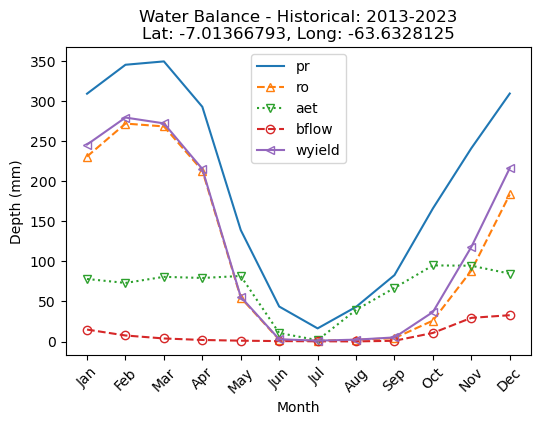

In [41]:
# Plot of monthly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_month.columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_month[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [42]:
# Let's assign year and month to each image
wy_coll = wy_coll.map(lambda image: image.set("year", ee.Image(image).date().get("year")))
wy_coll = wy_coll.map(lambda image: image.set("month", ee.Image(image).date().get("month")))

In [43]:
# Define a list of unique observation years from the image collection
years = ee.List(wy_coll.aggregate_array('year')).distinct().sort()

In [44]:
# Function to map over the list of years to build a list of image composites
def create_annual_composite(year, wb_vars):
    
    # Create initial band
    new_img = ee.Image(0).select([0], ["delete"]).float()
    bands = ee.List([wb_vars]).map(lambda wb_var: wy_coll.select(wb_var).filterMetadata('year', 'equals', year).reduce(ee.Reducer.sum()).set('year', year))

    # Add all Bands to our ee.Image
    new_image = new_img.addBands(ee.Image(bands))

    # Create a mask around area where pixels can effectively be calculated
    # Where we have have WHC
    mask = whc.gte(0)

    # Apply the mask
    new_image = new_image.updateMask(mask)

    # Add the new ee.Image to the ee.List
    return ee.List(annual_lst).add(new_image.select(new_image.bandNames().slice(1)))

annual_lst = ee.List([])
# Map over the list of years to generate the list of composites
annual_ic = ee.ImageCollection(ee.List([years]).map(create_annual_composite, wb_vars))

In [45]:
# Function to create an annual composite
def create_annual_composite(year):
    
    # Map over the list of wb_vars to create the composite image for the year
    def create_band(wb_var):
        return wy_coll \
            .select(wb_var) \
            .filterMetadata('year', 'equals', year) \
            .reduce(ee.Reducer.sum()) \
            .set('year', year)
    
    # Collect the bands
    bands = ee.List(wb_vars).map(create_band)
    
    # Combine all bands into one image
    new_image = ee.ImageCollection(bands).toBands().rename(wb_vars)
    
    # Mask the image using WHC
    mask = whc.gte(0)
    new_image = new_image.updateMask(mask)
    
    return new_image

# Map over the list of years to generate the list of composites
annual_ic = ee.ImageCollection(ee.List(years).map(lambda year: create_annual_composite(year)))

In [46]:
# Define arguments for the getFilmstripThumbURL function parameters.
filmArgs = {
  "dimensions": 128,
  "region": zoi,
  "crs": 'EPSG:3857',
  "min": -40.0,
  "max": 35.0,
  "palette": ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

# Print a URL that will produce the filmstrip when accessed.
print(annual_ic.getFilmstripThumbURL(filmArgs))

EEException: Image.select, argument 'bandSelectors': Invalid type.
Expected type: List<Object>.
Actual type: String.
Actual value: pr

In [ ]:
#############################
# HELPFUL CODES
#############################

# To know how many bands an ImageCollection has
#terraclimate.size().getInfo()

# To get the attributes (columns) as pandas dataframe
#geemap.ee_to_df(hydrobasins)

# Display imaga metada
#display(ee.ImageCollection.first())

In [ ]:
# Access an image asset from my account to test the code
#guate_bdry = ee.FeatureCollection('users/jvg/guatemala_buffer')
#guate_geom = guate_bdry.geometry()
#Map.centerObject(guate_geom)
#Map.addLayer(guate_bdry, {"color": 'red'}, 'Guatemala Boundary')